# A study over the SST of the Northern Adriatic Sea 

In the following notebook, we plot the Sea Surface Temperature (SST) of different areas of the Northern Adriatic Sea and compare it against a seasonal climatology based on data collected since January 1, 1987.

The data will be downloaded from the Copernicus Marine Data Store. The products we use are:
- [Mediterranean Sea Physics Reanalysis](https://data.marine.copernicus.eu/product/MEDSEA_MULTIYEAR_PHY_006_004/services) for the daily temperature over the Northern Adriatic Sea since January 1, 1987 up to December 31, 2021.
- [Mediterranean Sea Physics Analysis and Forecast](https://data.marine.copernicus.eu/product/MEDSEA_ANALYSISFORECAST_PHY_006_013/services) for the daily temperature over the Northern Adriatic Sea since January 1, 2022 up to the most recent data available.
- [Mediterranean Sea - High Resolution L4 Sea Surface Temperature Reprocessed](https://data.marine.copernicus.eu/product/SST_MED_SST_L4_REP_OBSERVATIONS_010_021/description) as a comparison against the data from the models

In [ ]:
import copernicusmarine
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import xarray as xr


ADRIATIC_LATITUDES = (40.0, 45.979)
ADRIATIC_LONGITUDES = (11.5, 20)


analysis_dataset = copernicusmarine.open_dataset(
    dataset_id = 'cmems_mod_med_phy-tem_anfc_4.2km_P1D-m',
    minimum_longitude = ADRIATIC_LONGITUDES[0],
    maximum_longitude = ADRIATIC_LONGITUDES[1],
    minimum_latitude = ADRIATIC_LATITUDES[0],
    maximum_latitude = ADRIATIC_LATITUDES[1],
    minimum_depth = 0,
    maximum_depth = 1,
    variables = ['thetao']
)

reanalysis_dataset = copernicusmarine.open_dataset(
    dataset_id = 'med-cmcc-tem-rean-d',
    minimum_longitude = ADRIATIC_LONGITUDES[0],
    maximum_longitude = ADRIATIC_LONGITUDES[1],
    minimum_latitude = ADRIATIC_LATITUDES[0],
    maximum_latitude = ADRIATIC_LATITUDES[1],
    minimum_depth = 0,
    maximum_depth = 1,
    variables = ['thetao']
)

satellite_dataset = copernicusmarine.open_dataset(
    dataset_id = 'cmems_SST_MED_SST_L4_REP_OBSERVATIONS_010_021',
    minimum_longitude = ADRIATIC_LONGITUDES[0],
    maximum_longitude = ADRIATIC_LONGITUDES[1],
    minimum_latitude = ADRIATIC_LATITUDES[0],
    maximum_latitude = ADRIATIC_LATITUDES[1],
    variables = ['analysed_sst']
)


analysis_data = analysis_dataset['thetao'].squeeze('depth')
reanalysis_data = reanalysis_dataset['thetao'].squeeze('depth')

satellite_data = satellite_dataset['analysed_sst'] - 273.15


In [2]:
# We concatenate the data from the two models; in this way we have a single big dataset
# with all the data from the models; because there is an temporal overlap between the
# data of the two models, we use January 1, 2022 as a reference point to decide where
# to split the two datasets
reanalysis_limit = datetime.strptime('2022-01-01T00:00:00', '%Y-%m-%dT%H:%M:%S')

model_data = xr.concat(
    (
        reanalysis_data.sel(time=slice(None, reanalysis_limit - timedelta(1))),
        analysis_data.sel(time=slice(reanalysis_limit, None))
    ),
    dim='time'
)

### Geometry tools

The data we have just downloaded contains information for each cell; for example, for a specific time frame we can draw a map

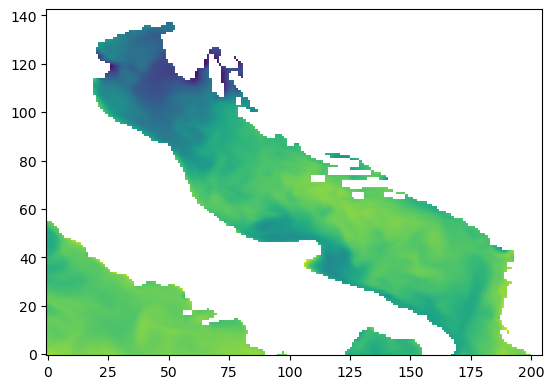

In [3]:
_ = plt.imshow(model_data.sel(time='2020-05-01'), origin='lower')

In this section of the notebook, we develop some tools to compute the spatial average of the information inside a specific region. This requires to compute the boundaries and the area of the cells starting from the only data that we have: the position of the centers of the cells.

To address this, we'll approximate the area of a cell by multiplying the distance between its two sides, using the line passing through the center of the cell (refer to the following image, where each center is marked with a blue dot).

![grid](images/grid.png)

In [4]:
import numpy  as np
from geopy.distance import geodesic
from itertools import product as cart_prod

In [5]:
def midpoints(points: np.ndarray):
    """
    Given a 1D array of points, compute the coordinates of
    the midpoint between each pair of adjacent points.
    In other words, `output[i]` represents the midpoint
    between `points[i]` and `points[i - 1]`.

    `output[0]` is chosen such that `points[0]` is the
    midpoint between `output[0]` and `output[1]`. The
    last midpoint is also computed following the same
    criteria.
    """
    n_points = points.shape[0]
    output = np.zeros(n_points + 1, dtype=points.dtype)
    for i in range(1, n_points):
        output[i] = (points[i] + points[i - 1]) / 2
    output[0] = 2 * points[0] - output[1]
    output[n_points] = 2 * points[n_points - 1] - output[n_points - 1]
    return output

In [6]:
def compute_cell_areas(center_latitude: np.ndarray, center_longitude: np.ndarray):
    """
    Compute the approximate area of the cells of a 2D grid given
    the coordinates of the centers of the cells

    Return a 2D array of the same shape of the grid
    """
    grid_latitude = midpoints(center_latitude)
    grid_longitude = midpoints(center_longitude)

    cells_y = center_latitude.shape[0]
    cells_x = center_longitude.shape[0]

    cell_widths = np.zeros((cells_y, cells_x), dtype=np.float32)
    cell_heights = np.zeros((cells_y, cells_x), dtype=np.float32)

    # Now we compute the size of the horizontal lines that cross
    # every cell
    for x, y in cart_prod(range(cells_x), range(cells_y)):
        line_start = (center_latitude[y], grid_longitude[x])
        line_end = (center_latitude[y], grid_longitude[x + 1])
        line_length = geodesic(line_start, line_end).km
        cell_widths[y, x] = line_length

    # Now the same for the vertical ones
    for x, y in cart_prod(range(cells_x), range(cells_y)):
        line_start = (grid_latitude[y], center_longitude[x])
        line_end = (grid_latitude[y + 1], center_longitude[x])
        line_length = geodesic(line_start, line_end).km
        cell_heights[y, x] = line_length

    # Because cell_widths and cell_heights have the same shape, numpy
    # "broadcasts" the operation on each element of the two arrays
    cell_areas = cell_widths * cell_heights
    return cell_areas

In [7]:
def average_cell_data(data, basin=None):
    """
    Compute the spatial average of a specific variable on the cells
    of the models (the ones that are not classified as "land").

    If a "basin" is specified, only the cells that are inside the
    basin are involved in the computation of the average.

    Return a 1D xArray DataArray with the averages along the time
    frames of the data.
    """
    data_coords = data.latitude.to_numpy(), data.longitude.to_numpy()
    cell_area = compute_cell_areas(*data_coords)

    water_cells = np.logical_not(np.isnan(data[0, :])).to_numpy()

    if basin is None:
        valid_cells = water_cells
    else:
        latitude = data_coords[0]
        longitude = data_coords[1].reshape((-1, 1))

        basin_cells = basin.is_inside(longitude, latitude).T
        valid_cells = np.logical_and(basin_cells, water_cells)

    data_on_valid_cells = xr.DataArray(
        data.to_numpy()[:, valid_cells],
        dims=('time', 'cells'),
        coords={'time': data.time}
    )

    total_area = np.sum(cell_area[valid_cells])
    return np.sum(data_on_valid_cells * cell_area[valid_cells], axis=-1) / total_area
    


In the next cell, we plot the temperature trend of all the data we have downloaded. This is not particularly useful since the variability of the climate throughout the year obscures other trends. In the next section of the notebook, instead, we will study the seasonal trends by analyzing the data year by year.

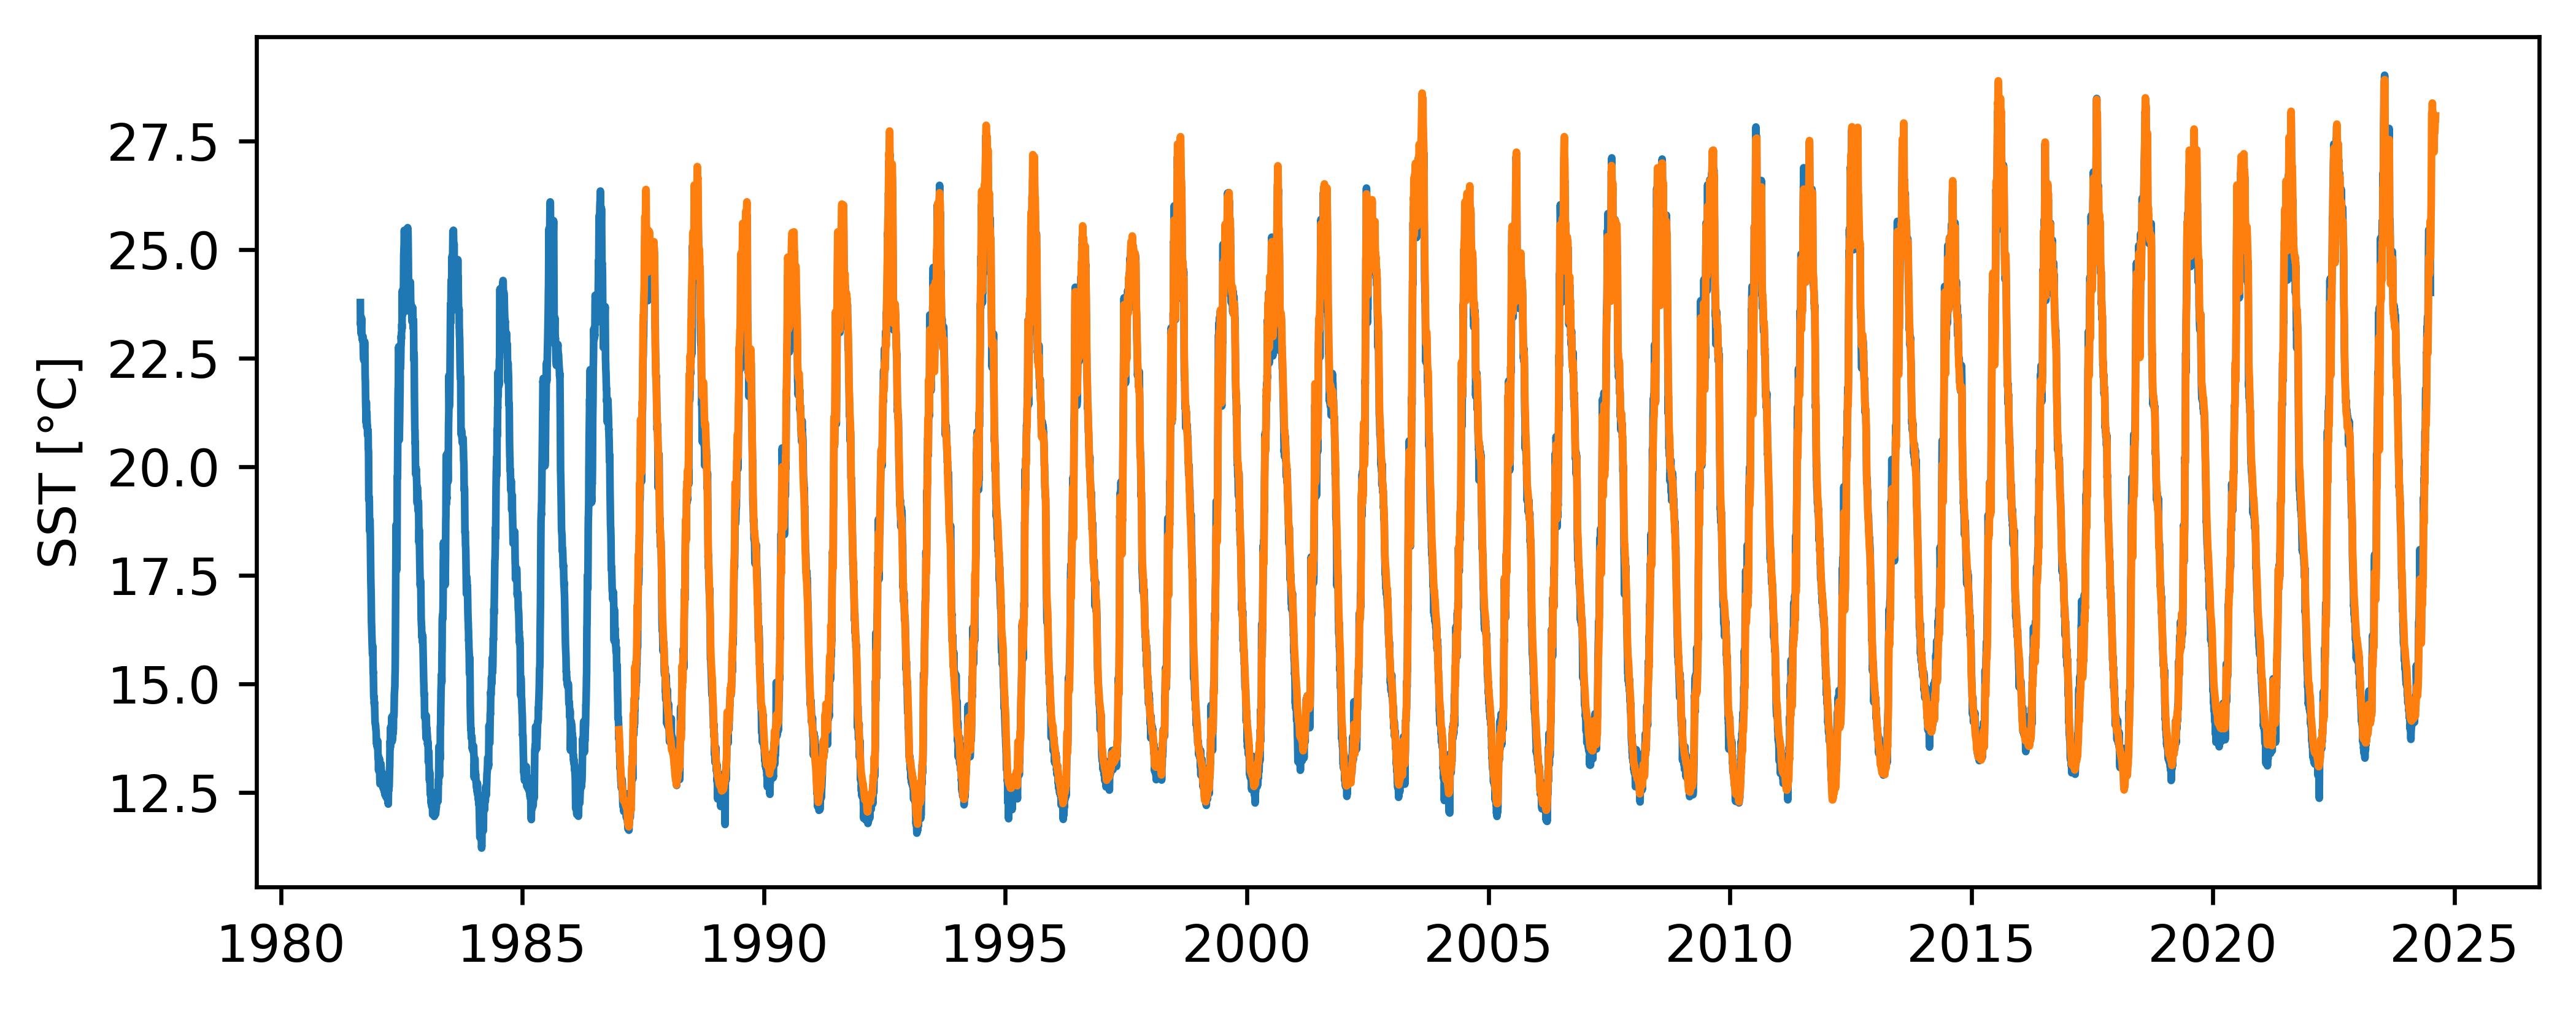

In [8]:
def plot_trends():
    sat_data_averages = average_cell_data(satellite_data)
    model_data_averages = average_cell_data(model_data)

    plt.plot(sat_data_averages.time, sat_data_averages)
    plt.plot(model_data_averages.time, model_data_averages)

    return

plt.figure(dpi=600, figsize=(8, 3))
plot_trends()
plt.ylabel('SST [°C]')
plt.show()
plt.close()

## Seasonal Trends

In [9]:
from collections import OrderedDict
import matplotlib.ticker as ticker
from scipy.interpolate import interp1d

In [10]:
def get_year(dtime: np.datetime64) -> int:
    """
    Given a NumPy `datetime64` object that represents a date, return
    the year of the date
    """
    return dtime.astype('datetime64[Y]').astype(int) + 1970


def day_of_week_num(dts: np.datetime64) -> int:
    """
    Given a NumPy `datetime64` object that represents a date, return
    the day of the week as an integer. Monday is 0, Tuesday is 1, and
    so on...
    """
    return int((dts.astype('datetime64[D]').view('int64') - 4) % 7)


def slice_data_on_year(data: xr.DataArray, year: int) -> xr.DataArray:
    """
    Given a XArray `DataArray` that contains a coordinate named "time", return
    all the elements of the array whose time frame falls within the specified
    year
    """
    indices = []
    dates = np.asarray(data.time)
    year_start = np.datetime64('{:0>4}-01-01T00:00:00.00000000'.format(year), 'ns')
    year_end = np.datetime64('{:0>4}-01-01T00:00:00.00000000'.format(year + 1), 'ns')
    good_dates = np.logical_and(dates >= year_start, dates < year_end)
    return data[good_dates]


def split_analysis_and_forecast(data):
    """
    Some of the data downloaded from the model are forecasts, meaning they
    are predictions for dates in the future relative to when the model was run.

    This function split the data in two parts: the one related to the analysis
    and the forecasts.
    """
    indices = []
    dates = data.time.values

    # Start from the last dates
    last_analysis = dates[-1]

    # We look for the first Tuesday in the past
    while last_analysis > np.datetime64('now') or day_of_week_num(last_analysis) != 1:
         last_analysis -= np.timedelta64(1, 'D')

    good_dates = dates <= last_analysis
    return data[good_dates], data[~good_dates]


Here we prepare some tools to split the data an to analyze the trends among different years

In [11]:
class YearData:
    """
    An YearData contains all the information we need to represent an year and its
    associated plot.

    Internally, it represents the data as a function between 0 and 1, where 0 is
    the first day of the year and 1 is the last. 
    """
    def __init__(self, year:int, year_data: np.ndarray):
        self.year = int(year)
        self.data = year_data
        self.n_points = self.data.shape[0]

        # Now we define self.x_points, an array where we rescale the dates
        # of the year between 0 and 1 (so 0 is January 1st, 1 / 365. is
        # Janauary 2nd, and so on). In this way, we can plot the data
        # for the year as a function between 0 and 1. We leave an empty
        # space for the 29th of February if the year is not leap.
        x_points = np.linspace(0, 1, 366)
        if not self.is_leap():
            x_points_no_leap = np.empty((365,), dtype=x_points.dtype)
            x_points_no_leap[:31 + 28] = x_points[:31 + 28]
            x_points_no_leap[31 + 28:] = x_points[31 + 29:]
            self.x_points = x_points_no_leap[:self.n_points]
        else:
            self.x_points = x_points[:self.n_points]

        self._data_function = interp1d(
            x=self.x_points,
            y=self.data,
            kind='cubic'
        )

    def is_leap(self) -> bool:
        """
        Return `True` if the year is leap, `False` otherwise
        """
        if self.year % 400 == 0:
            return True
        if self.year % 100 == 0:
            return False
        return self.year % 4 == 0
    
    @property
    def n_days(self) -> int:
        """
        Return the number of days of the year
        """
        return 366 if self.is_leap() else 365

    def is_complete(self):
        """
        Return `True` if we have data for all the days of the year,
        `False` otherwise
        """
        return self.n_points == self.n_days

    def get_plot_data(self):
        return self.x_points, self.y_points

    def evaluate_on(self, q_values: np.ndarray) -> np.ndarray:
        """
        Given an array `q_values` of floating point numbers between 0 and
        1, return an array with the values saved inside this object for that
        fraction of the year.
        """
        return self._data_function(q_values)

    def plot(self, start=0, color=None, alpha=None, linewidth=None,
             linestyle=None, zorder=None, label=None):
        """
        Plot the content of this `DataYear` as a function of the time
        (between 0 and 1).

        If `start` is not 0m the first `start` points will be droped
        """
        if color is None:
            color = 'black'
        if alpha is None:
            alpha = 1.
        if linewidth is None:
            linewidth = 0.5
        if zorder is None:
            zorder = 1
        kwargs = {}
        if label is not None:
            kwargs['label'] = label
        if linestyle is not None:
            kwargs['linestyle'] = linestyle

        return plt.plot(
            self.x_points[start:],
            self.data[start:],
            alpha=alpha,
            color=color,
            linewidth=linewidth,
            zorder=zorder,
            **kwargs
        )

    def __repr__(self):
        return 'YearData({}, ...)'.format(self.year)

In [12]:
class SeasonalDataset(OrderedDict):
    """
    A `SeasonalDataset` is an ordered dictionary that associates to each
    year its corresponding data (as a `YearData` object).

    It is constructed starting from an XArray DataArray that contains the
    values on the cells of the first layer.
    """
    def __init__(self, cell_data, basin=None):
        time_frames = cell_data.time.to_numpy()
        first_frame = np.min(time_frames)
        first_year = get_year(first_frame)

        last_year = get_year(np.max(time_frames))

        # If the data for the first year do not start from January, 1st, we skip
        # the first year and start with the second one, so we are sure that the year
        # is complete
        first_year_start = np.datetime64(f'{first_year}-01-01', 's')
        if first_frame - first_year_start > np.timedelta64(60 * 60 * 14, 's'):
            first_year += 1
            cell_data = cell_data.sel(time=slice(f'{first_year}-01-01', None))

        averaged_data = average_cell_data(cell_data, basin)
        
        for year in range(first_year, last_year + 1):
            data_per_year = slice_data_on_year(averaged_data, year)
            self[year] = YearData(year, data_per_year)


In [13]:
class DatasetStatistics:
    """
    A `DatasetStatistics` is an object capable of computing various
    statistical indicators over a SeasonalDataset. These indicators
    contain a single value for each day of the year, calculated by
    aggregating the data for that day across different years
    """
    def __init__(self, dataset: SeasonalDataset):
        complete_years = tuple(
            year for year in dataset.values() if year.is_complete()
        )

        self._all_data = np.empty((len(complete_years), 366), dtype=np.float32)
        self._x_points = np.linspace(0, 1, 366)
        self._x_points.setflags(write=False)

        for i, year in enumerate(complete_years):
            self._all_data[i, :] = year.evaluate_on(self._x_points)

    def _reduce(self, aggregator):
        return aggregator(self._all_data, axis=0)
    
    def average(self):
        return self._reduce(np.average)

    def std(self):
        return self._reduce(np.std)
    
    def max(self):
        return self._reduce(np.max)

    def min(self):
        return self._reduce(np.min)

    @property
    def x_points(self):
        return self._x_points


In [14]:
class SeasonalPlotter:
    """
    The `SeasonalPlotter` is the tool that we will use to plot the data we
    have downloaded from the Copernicus Marine Data Store.

    Indeed, it uses the global objets that we have created in the first
    two cells of this Jupyter Notebook.

    It produces a plot where the seasonal trend of the last two years
    is shown.
    """
    MONTH_LABELS = (
        'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
        'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
    )
    MONTH_LENGHTS = (
        31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31
    )

    def __init__(self,
                 basin=None,
                 model_current_year_color='red',
                 model_current_year_linewidth=0.7,
                 model_previous_year_color='orange',
                 model_previous_year_linewidth=0.7,
                 satellite_current_year_color='tab:blue',
                 satellite_current_year_linewidth=0.7,
                 satellite_previous_year_color='cyan',
                 satellite_previous_year_linewidth=0.7,
                 draw_climatology=True,
                 climatology_from_satellite=False,
                 draw_current_year=True,
                 draw_previous_year=True,
                 write_today_label=True,
                ):
        self.basin = basin
        self.model_current_year_color = model_current_year_color
        self.model_current_year_linewidth = model_current_year_linewidth
        self.model_previous_year_color = model_previous_year_color
        self.model_previous_year_linewidth = model_previous_year_linewidth
        self.satellite_current_year_color = satellite_current_year_color
        self.satellite_current_year_linewidth = satellite_current_year_linewidth
        self.satellite_previous_year_color = satellite_previous_year_color
        self.satellite_previous_year_linewidth = satellite_previous_year_linewidth
        self.draw_climatology = draw_climatology
        self.climatology_from_satellite = climatology_from_satellite
        self.draw_current_year = draw_current_year
        self.draw_previous_year = draw_previous_year
        self.write_today_label = write_today_label

        self._satellite_data = SeasonalDataset(satellite_data, basin)
        self._model_data = SeasonalDataset(model_data, basin)

        self._satellite_statistics = DatasetStatistics(self._satellite_data)
        self._model_statistics = DatasetStatistics(self._model_data)

    def _plot_climatology(self):
        if self.climatology_from_satellite:
            climatology_data = self._satellite_statistics
        else:
            climatology_data = self._model_statistics

        plt.plot(
            climatology_data.x_points,
            climatology_data.average(),
            color='black',
            linewidth=1,
            zorder=1,
            linestyle='--',
            label='average'
        )
        
        plt.fill_between(
            climatology_data.x_points,
            climatology_data.min(),
            climatology_data.average() - climatology_data.std(),
            alpha=0.3
        )
        
        plt.fill_between(
            climatology_data.x_points,
            climatology_data.average() - climatology_data.std(),
            climatology_data.average() + climatology_data.std(),
            alpha=0.2,
            color='green'
        )
        
        plt.fill_between(
            climatology_data.x_points,
            climatology_data.average() + climatology_data.std(),
            climatology_data.max(),
            alpha=0.2,
            color='orange'
        )

    def _plot_basin(self, figure):
        return
    
    def plot(self, **kwargs):
        title = None
        if 'title' in kwargs:
            title = kwargs['title']
            del kwargs['title']

        figure = plt.figure(**kwargs)

        current_year = datetime.now().year
        
        main_ax = plt.gca()

        self._plot_basin(figure)
    
        plt.sca(main_ax)          


        if self.draw_climatology:
            self._plot_climatology()            
        
        if self.draw_previous_year:
            self._satellite_data[current_year - 1].plot(
                color=self.satellite_previous_year_color,
                label='Satellite {}'.format(current_year - 1),
                linewidth=self.satellite_previous_year_linewidth,
                alpha=1,
                zorder=7
            )
        
        if self.draw_current_year:
            self._satellite_data[current_year].plot(
                color=self.satellite_current_year_color,
                label='Satellite {}'.format(current_year),
                linewidth=self.satellite_current_year_linewidth,
                alpha=1,
                zorder=7
            )
        
        if self.draw_previous_year:
            self._model_data[current_year - 1].plot(
                color=self.model_previous_year_color,
                label='CMEMS {}'.format(current_year - 1),
                linewidth=self.model_previous_year_linewidth,
                alpha=1,
                zorder=7
            )
        
        if self.draw_current_year:
            year_data = self._model_data[current_year]
            d_analysis, d_forecast = split_analysis_and_forecast(year_data.data)
            year_analysis = YearData(current_year, d_analysis)
            year_analysis.plot(
                color=self.model_current_year_color,
                label='CMEMS {}'.format(current_year),
                linewidth=self.model_current_year_linewidth,
                alpha=1,
                zorder=10
            )
            
            last_point_position = year_analysis.x_points[-1]
            last_point_value = d_analysis.to_numpy()[-1]
            last_point_date = str(d_analysis.time.to_numpy()[-1]).split('T')[0]
            
            if self.write_today_label:
                plt.plot(
                    (last_point_position,),
                    d_analysis[-1:],
                    marker='.',
                    color=self.model_current_year_color,
                    zorder=8
                )
                plt.text(
                    last_point_position,
                    last_point_value,
                    r'  $\bf{' + f'{last_point_value:.2f}' + '}$°' + f'\n  {last_point_date}',
                    color=self.model_current_year_color,
                    va='center',
                    zorder=8
                )
            
            year_data.plot(
                start=d_analysis.shape[0] - 1,
                linestyle=(0, (2, 1)),
                color=self.model_current_year_color,
                alpha=0.8,
                linewidth=self.model_current_year_linewidth,
                zorder=8
            )
        
        plt.gca().set_xlim(0, 1)
        # plt.gca().set_ylim(4, 32)
        # y_ticks = (5, 7.5, 10, 12.5, 15, 17.5, 20, 22.5, 25, 27.5, 30)
        # plt.gca().set_yticks(y_ticks)
        plt.gca().grid(axis='y', color=(0.5, 0.5, 0.9), linestyle='--', alpha=0.07, zorder=0, linewidth=0.6)

        
        for d in ('top', 'left', 'right'):
            plt.gca().spines[d].set_visible(False)
        
        x_ticks = tuple(sum(self.MONTH_LENGHTS[:i]) / 365 for i in range(13))
        middle_points = [(a + b) / 2 for a, b in zip(x_ticks[1:], x_ticks[:-1])]
        plt.gca().set_xticks(x_ticks)
        plt.gca().xaxis.set_minor_locator(ticker.FixedLocator(middle_points))
        plt.gca().xaxis.set_minor_formatter(ticker.FixedFormatter(self.MONTH_LABELS))
        plt.gca().xaxis.set_tick_params(which='minor',length=0, labelrotation=90)
        
        plt.gca().xaxis.set_major_formatter(ticker.NullFormatter())
        
        plt.ylabel('SST [°C]')
        if title is not None:
            plt.gca().set_title(title)

        plt.legend(loc='lower right', ncol=2, fontsize="8")


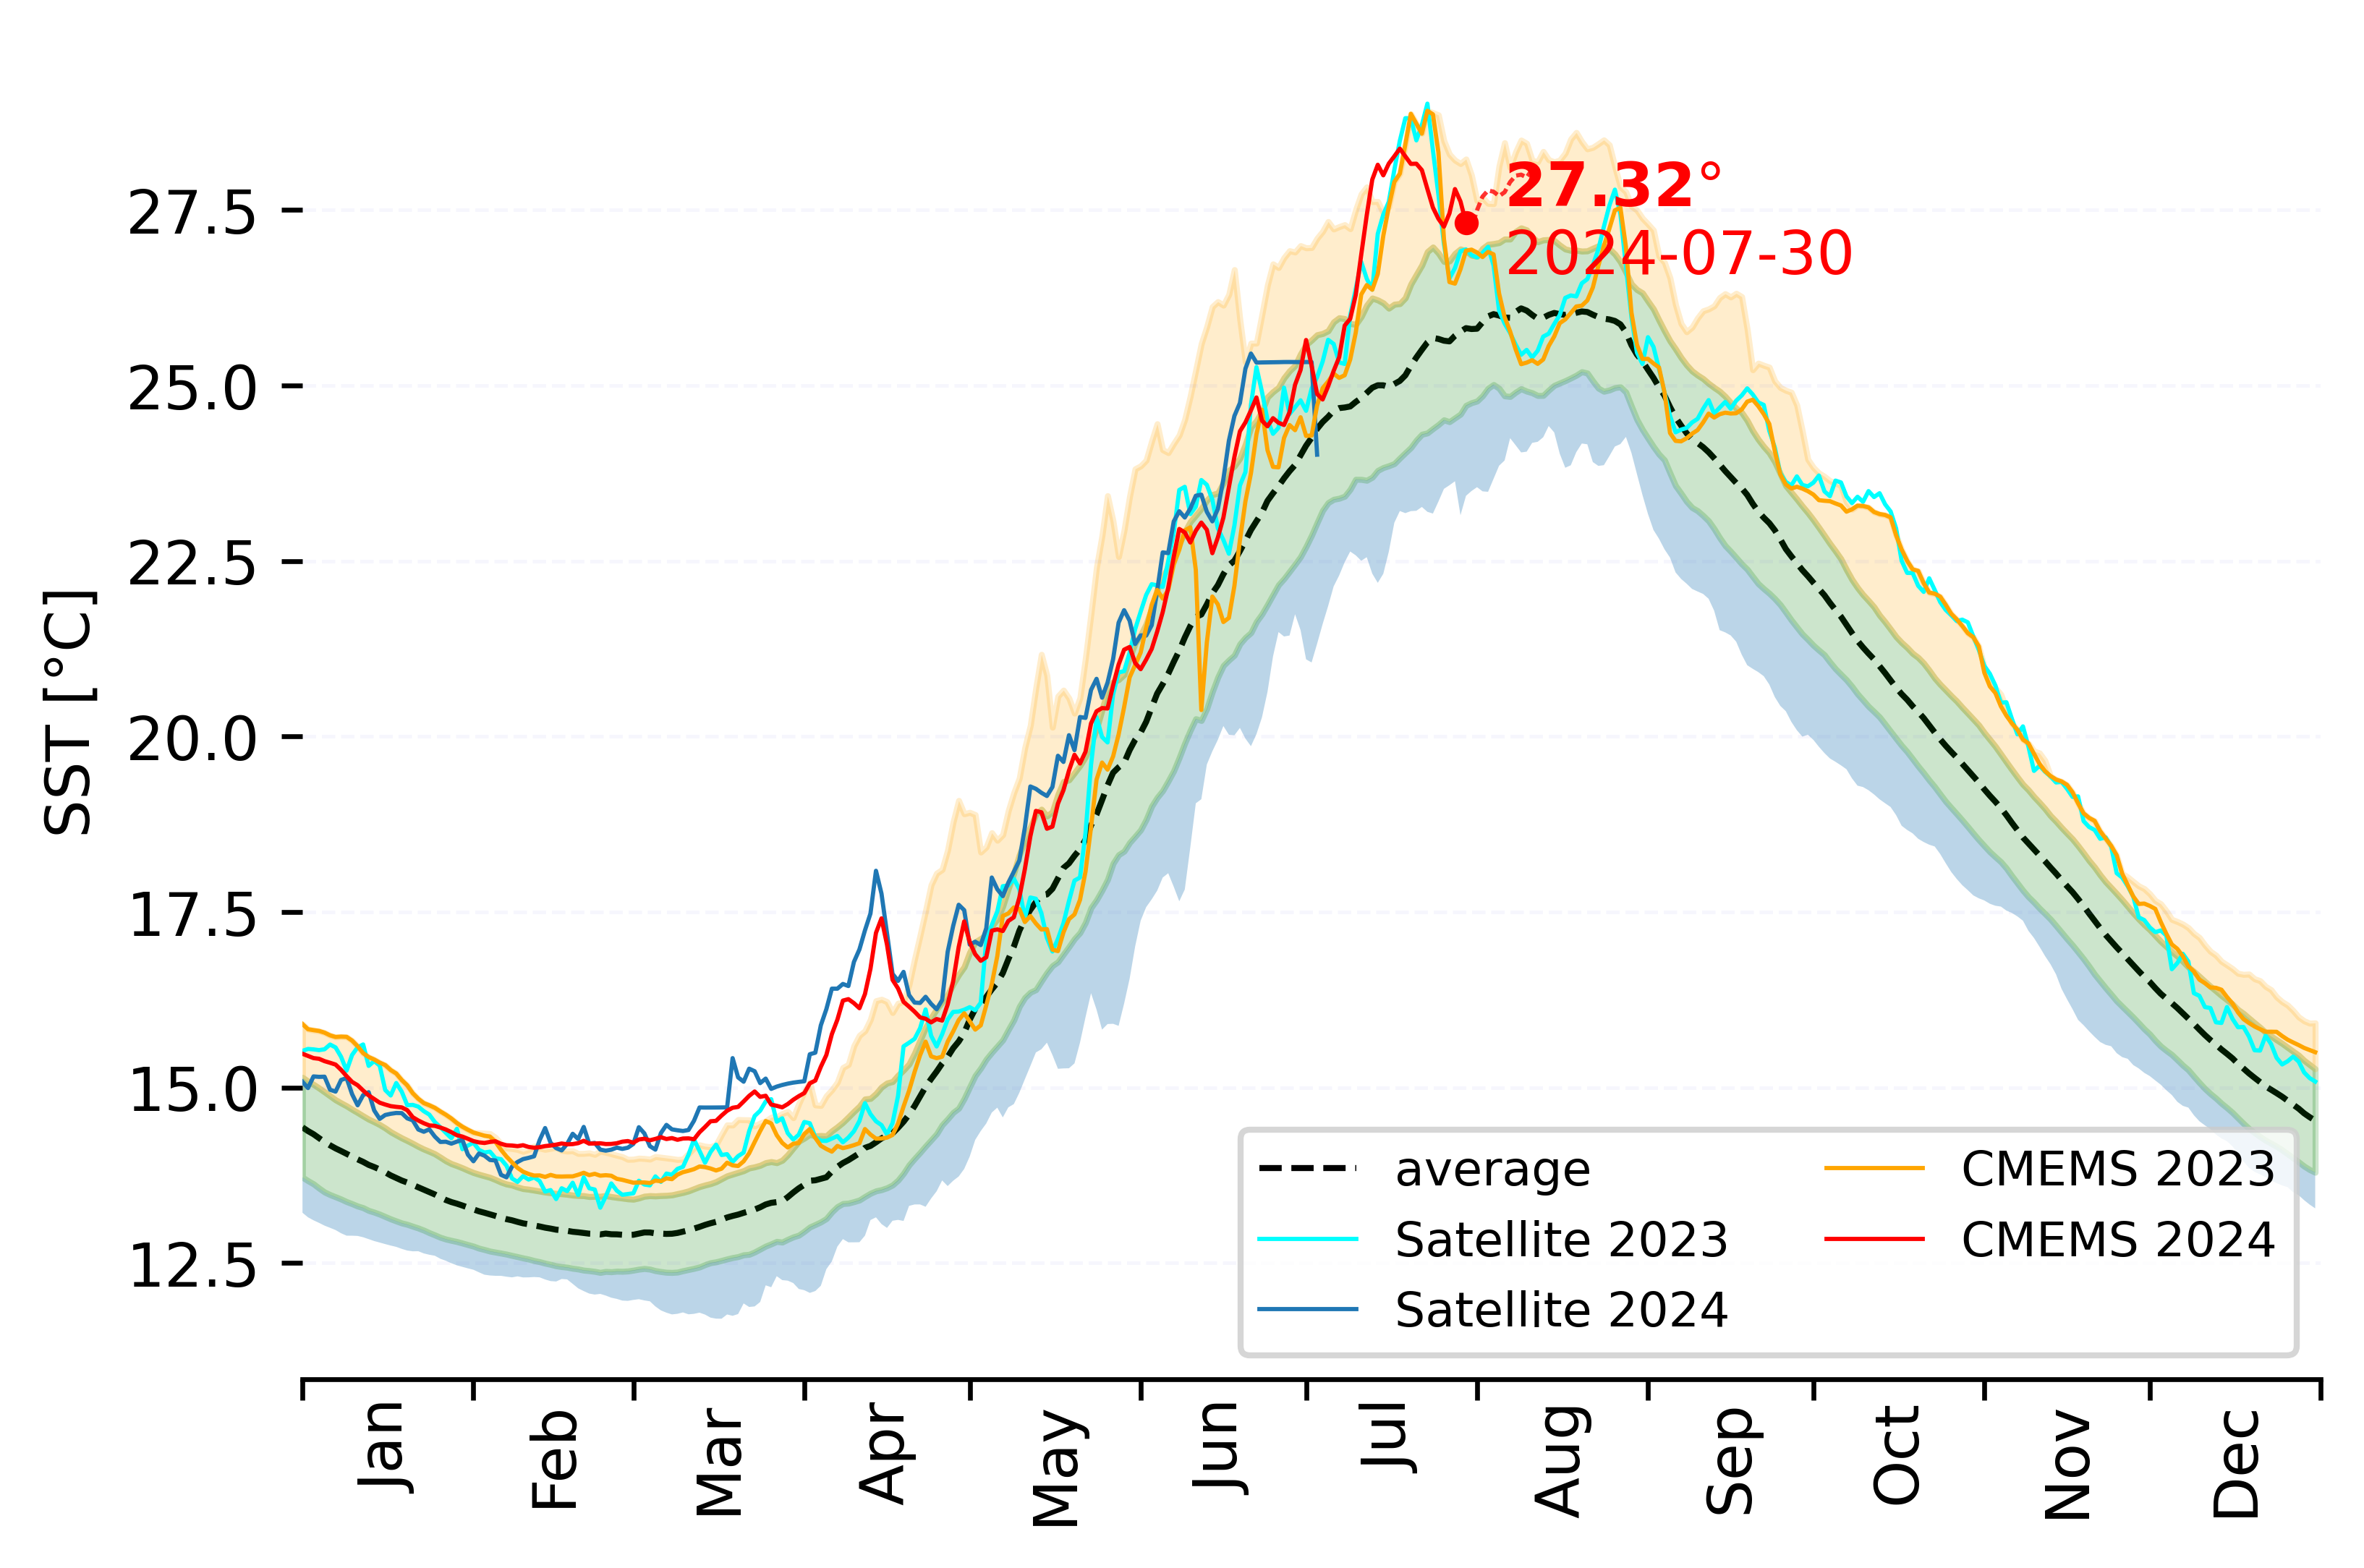

In [15]:
SeasonalPlotter().plot(dpi=600, figsize=(6,4))

## Exploring different basins

In the final part of this Jupyter Notebook, we focus on examining specific regions of the data we have downloaded.

For this reason, we identify 3 regions:
- The Gulf of Trieste
- All the points over the 45° North
- The North Adriatic Sea

To identify these areas, we use a dedicated library: `bit.sea`. Within this library, you can define custom `Basins` objects, while others, such as the North Adriatic Sea, are already implemented.

In [16]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Imports from bit.sea
from basins.basin import SimpleBasin
from basins.region import Rectangle
from basins.cadeau.nad_V0 import nad, get_zone_by_char

In [17]:
class SeasonalPlotterWithBasin(SeasonalPlotter):
    """
    This class extend the SeasonalPlotter by adding a routine
    that draws the area selected by the basin over the plot.

    We use `cartopy` to draw the geographic map of the basin
    """
    def _plot_basin(self, figure, lon_points=100, lat_points=100):
        if self.basin is None:
            return
        basin_ax = figure.add_axes([0.10, 0.55, 0.35, 0.3], projection=ccrs.Mercator())
        basin_ax.set_extent([12, 18.5, 42.2, 46], crs=ccrs.PlateCarree())
        self.basin.plot(
            lon_window=(12.0, 18.5),
            lat_window=(42.2, 46.0),
            lon_points=lon_points,
            lat_points=lat_points,
            axes=basin_ax,
            transform=ccrs.PlateCarree()
        )
        basin_ax.add_feature(cfeature.LAND, zorder=9, facecolor=(0.9, 0.9, 0.9))
        basin_ax.add_feature(cfeature.COASTLINE)

        return basin_ax

In [18]:
# We define the n45 basin by intersecting a rectangle with the
# nad (North Adriatic Sea) basin already implemented in bit.sea.
# This approach allows us to select only the points that are
# north of the 45° longitude.
R1 = Rectangle(11., 14., 45., 46.)
n45 = SimpleBasin('N45', R1.intersect(nad.region), 'North of 45°')

# Gulf of Trieste is also already implemented in bit.sea
gulf_of_trieste = get_zone_by_char('A')

basins = (nad, n45, gulf_of_trieste)

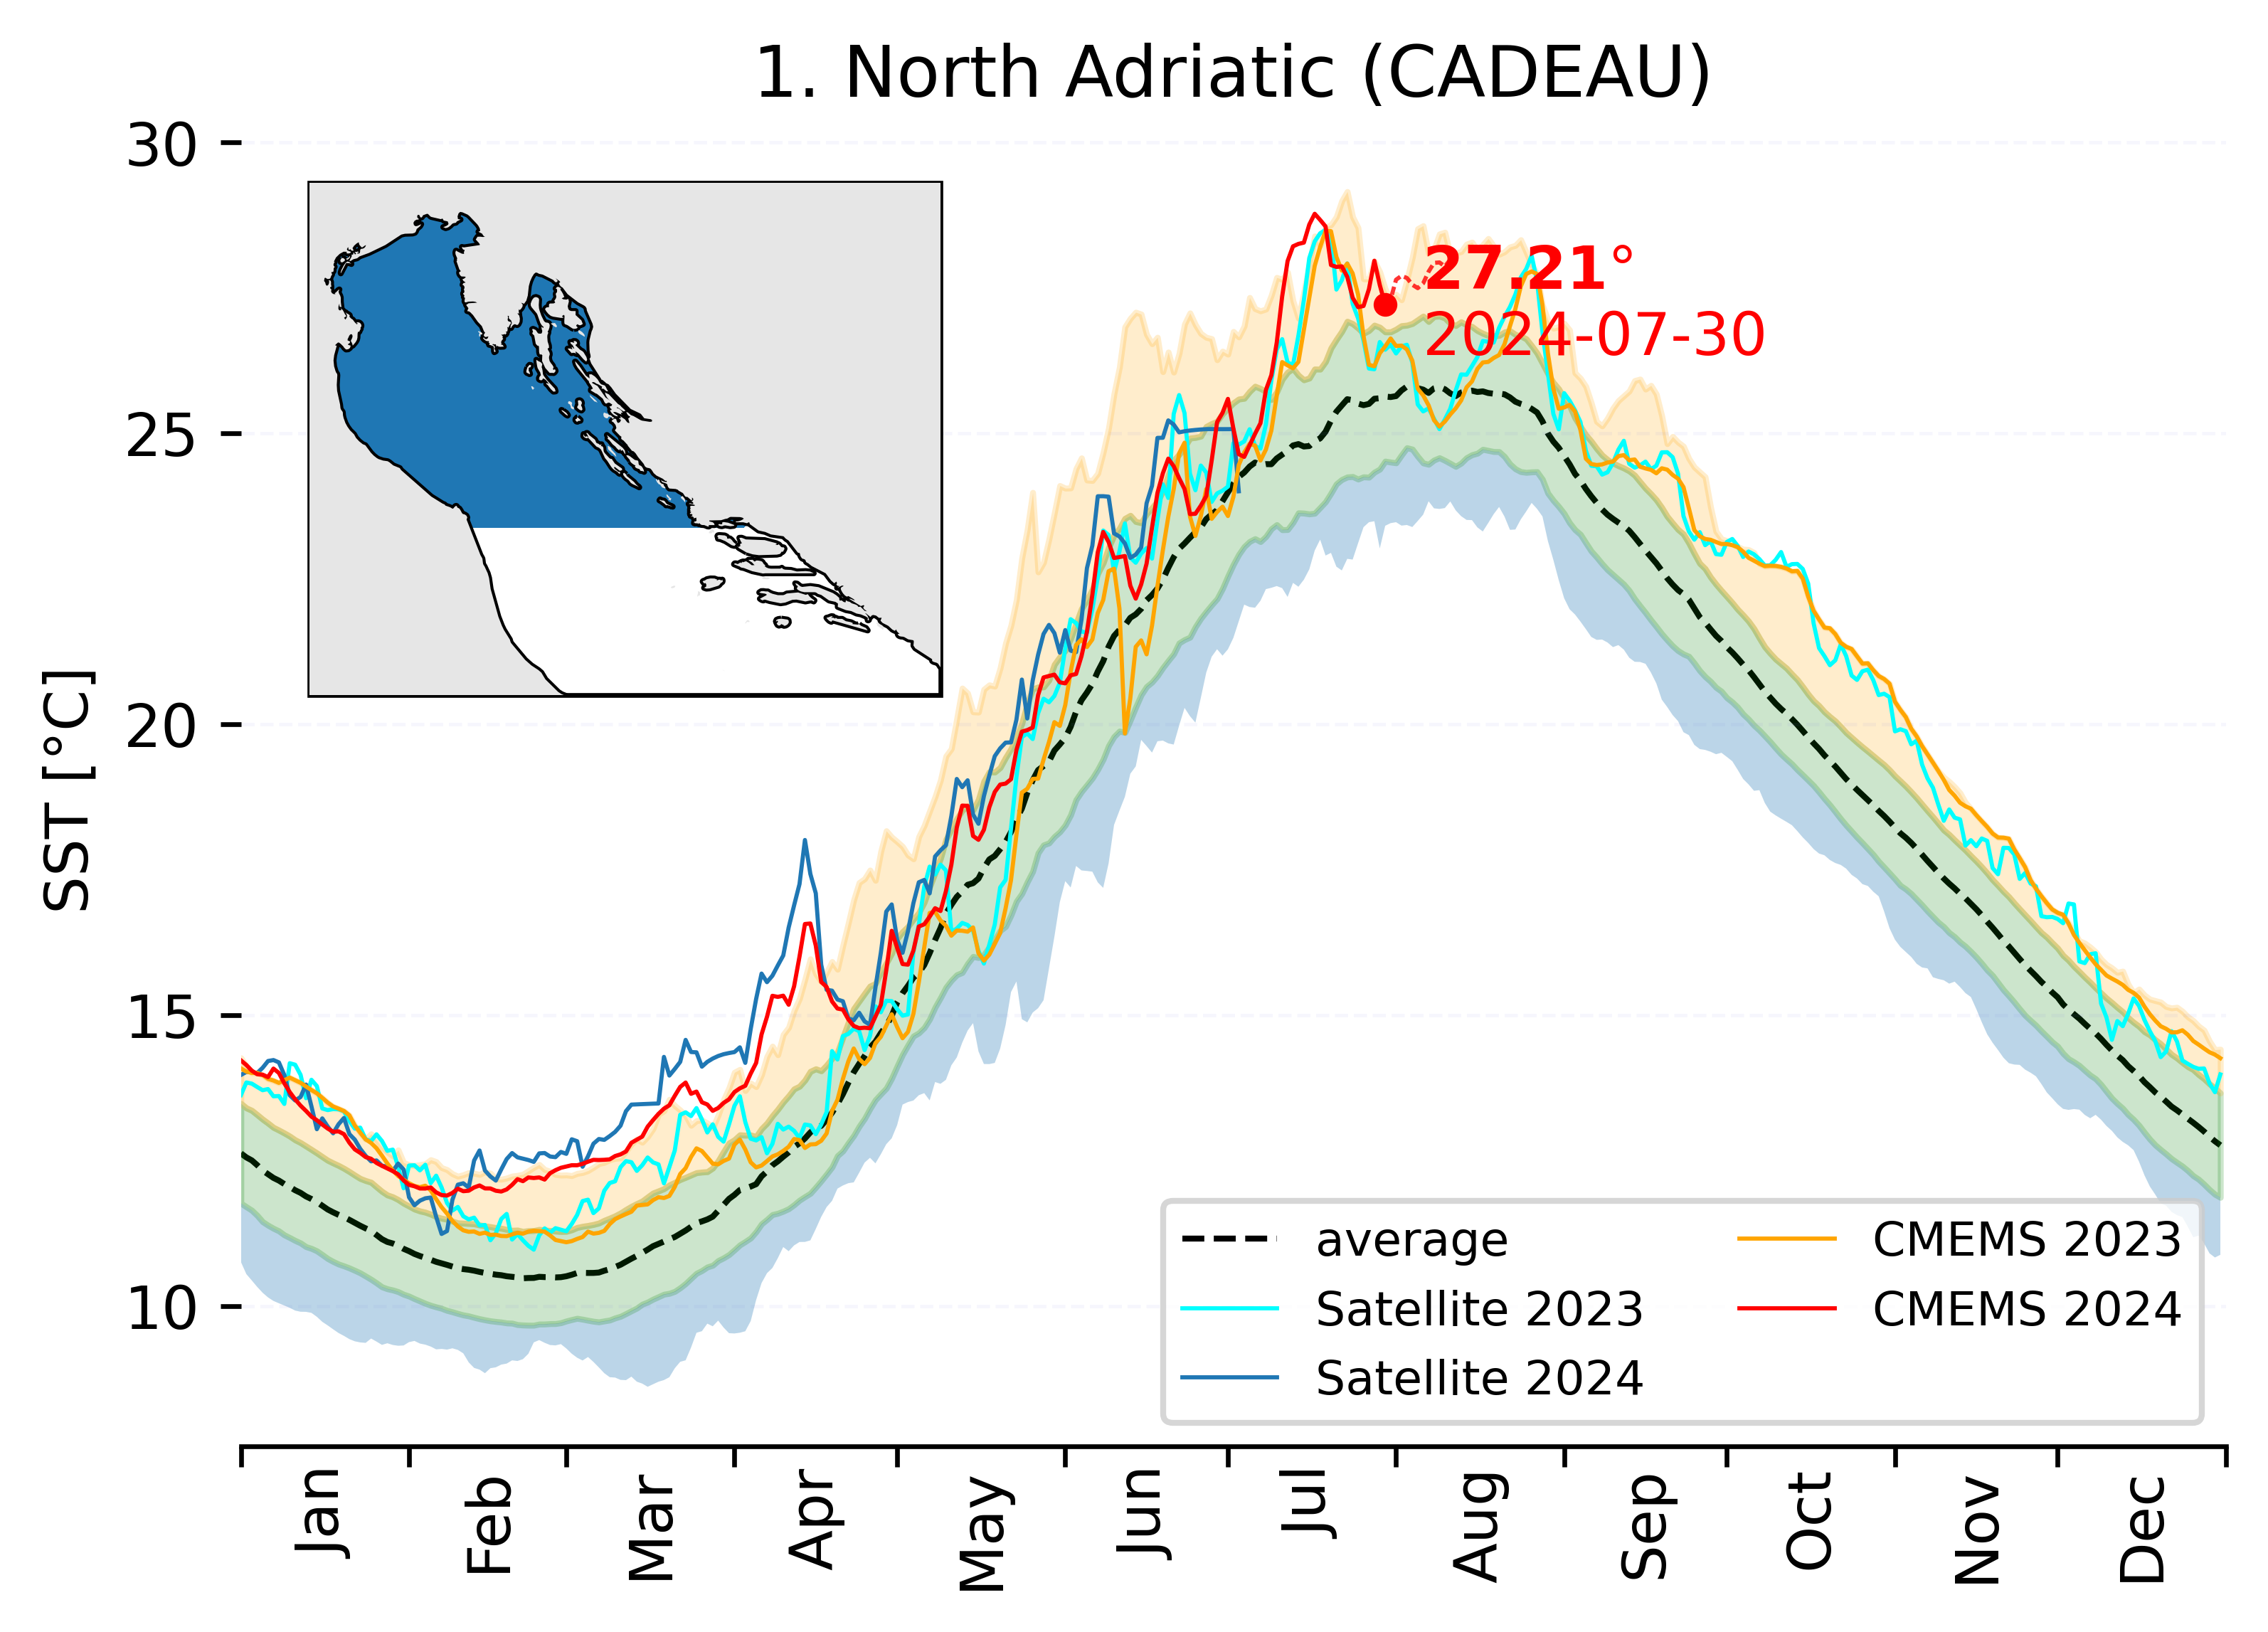

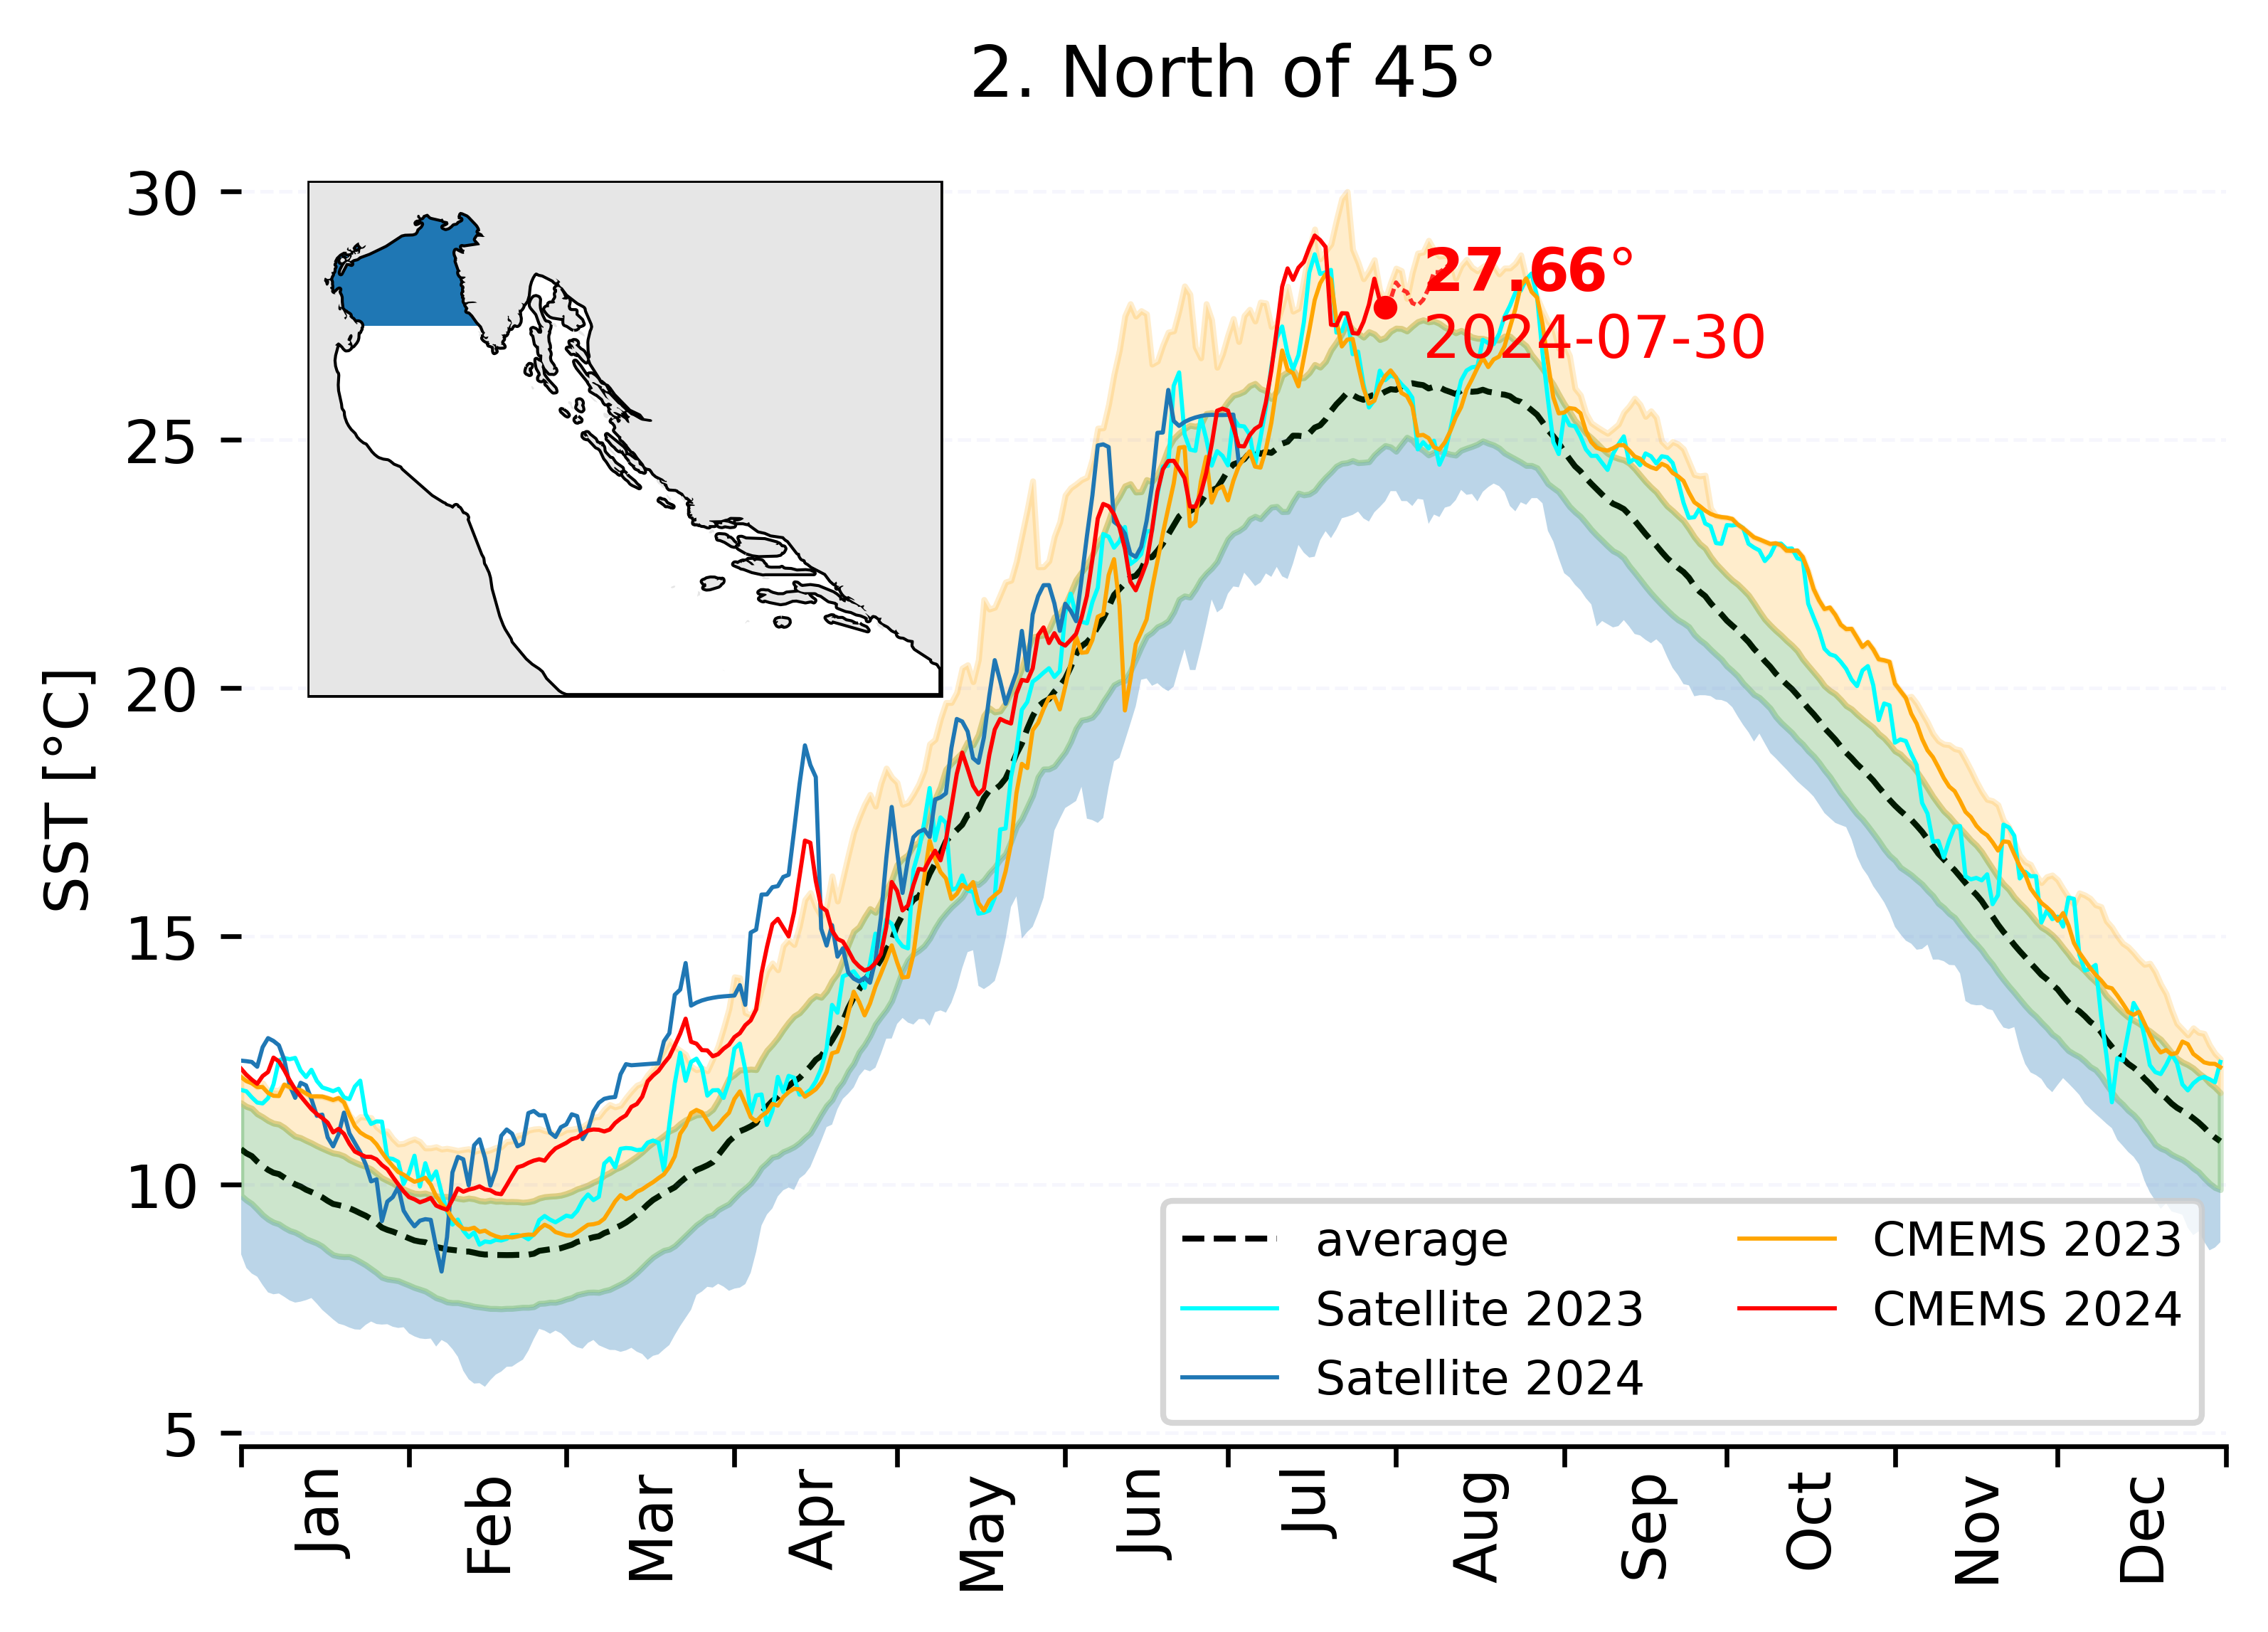

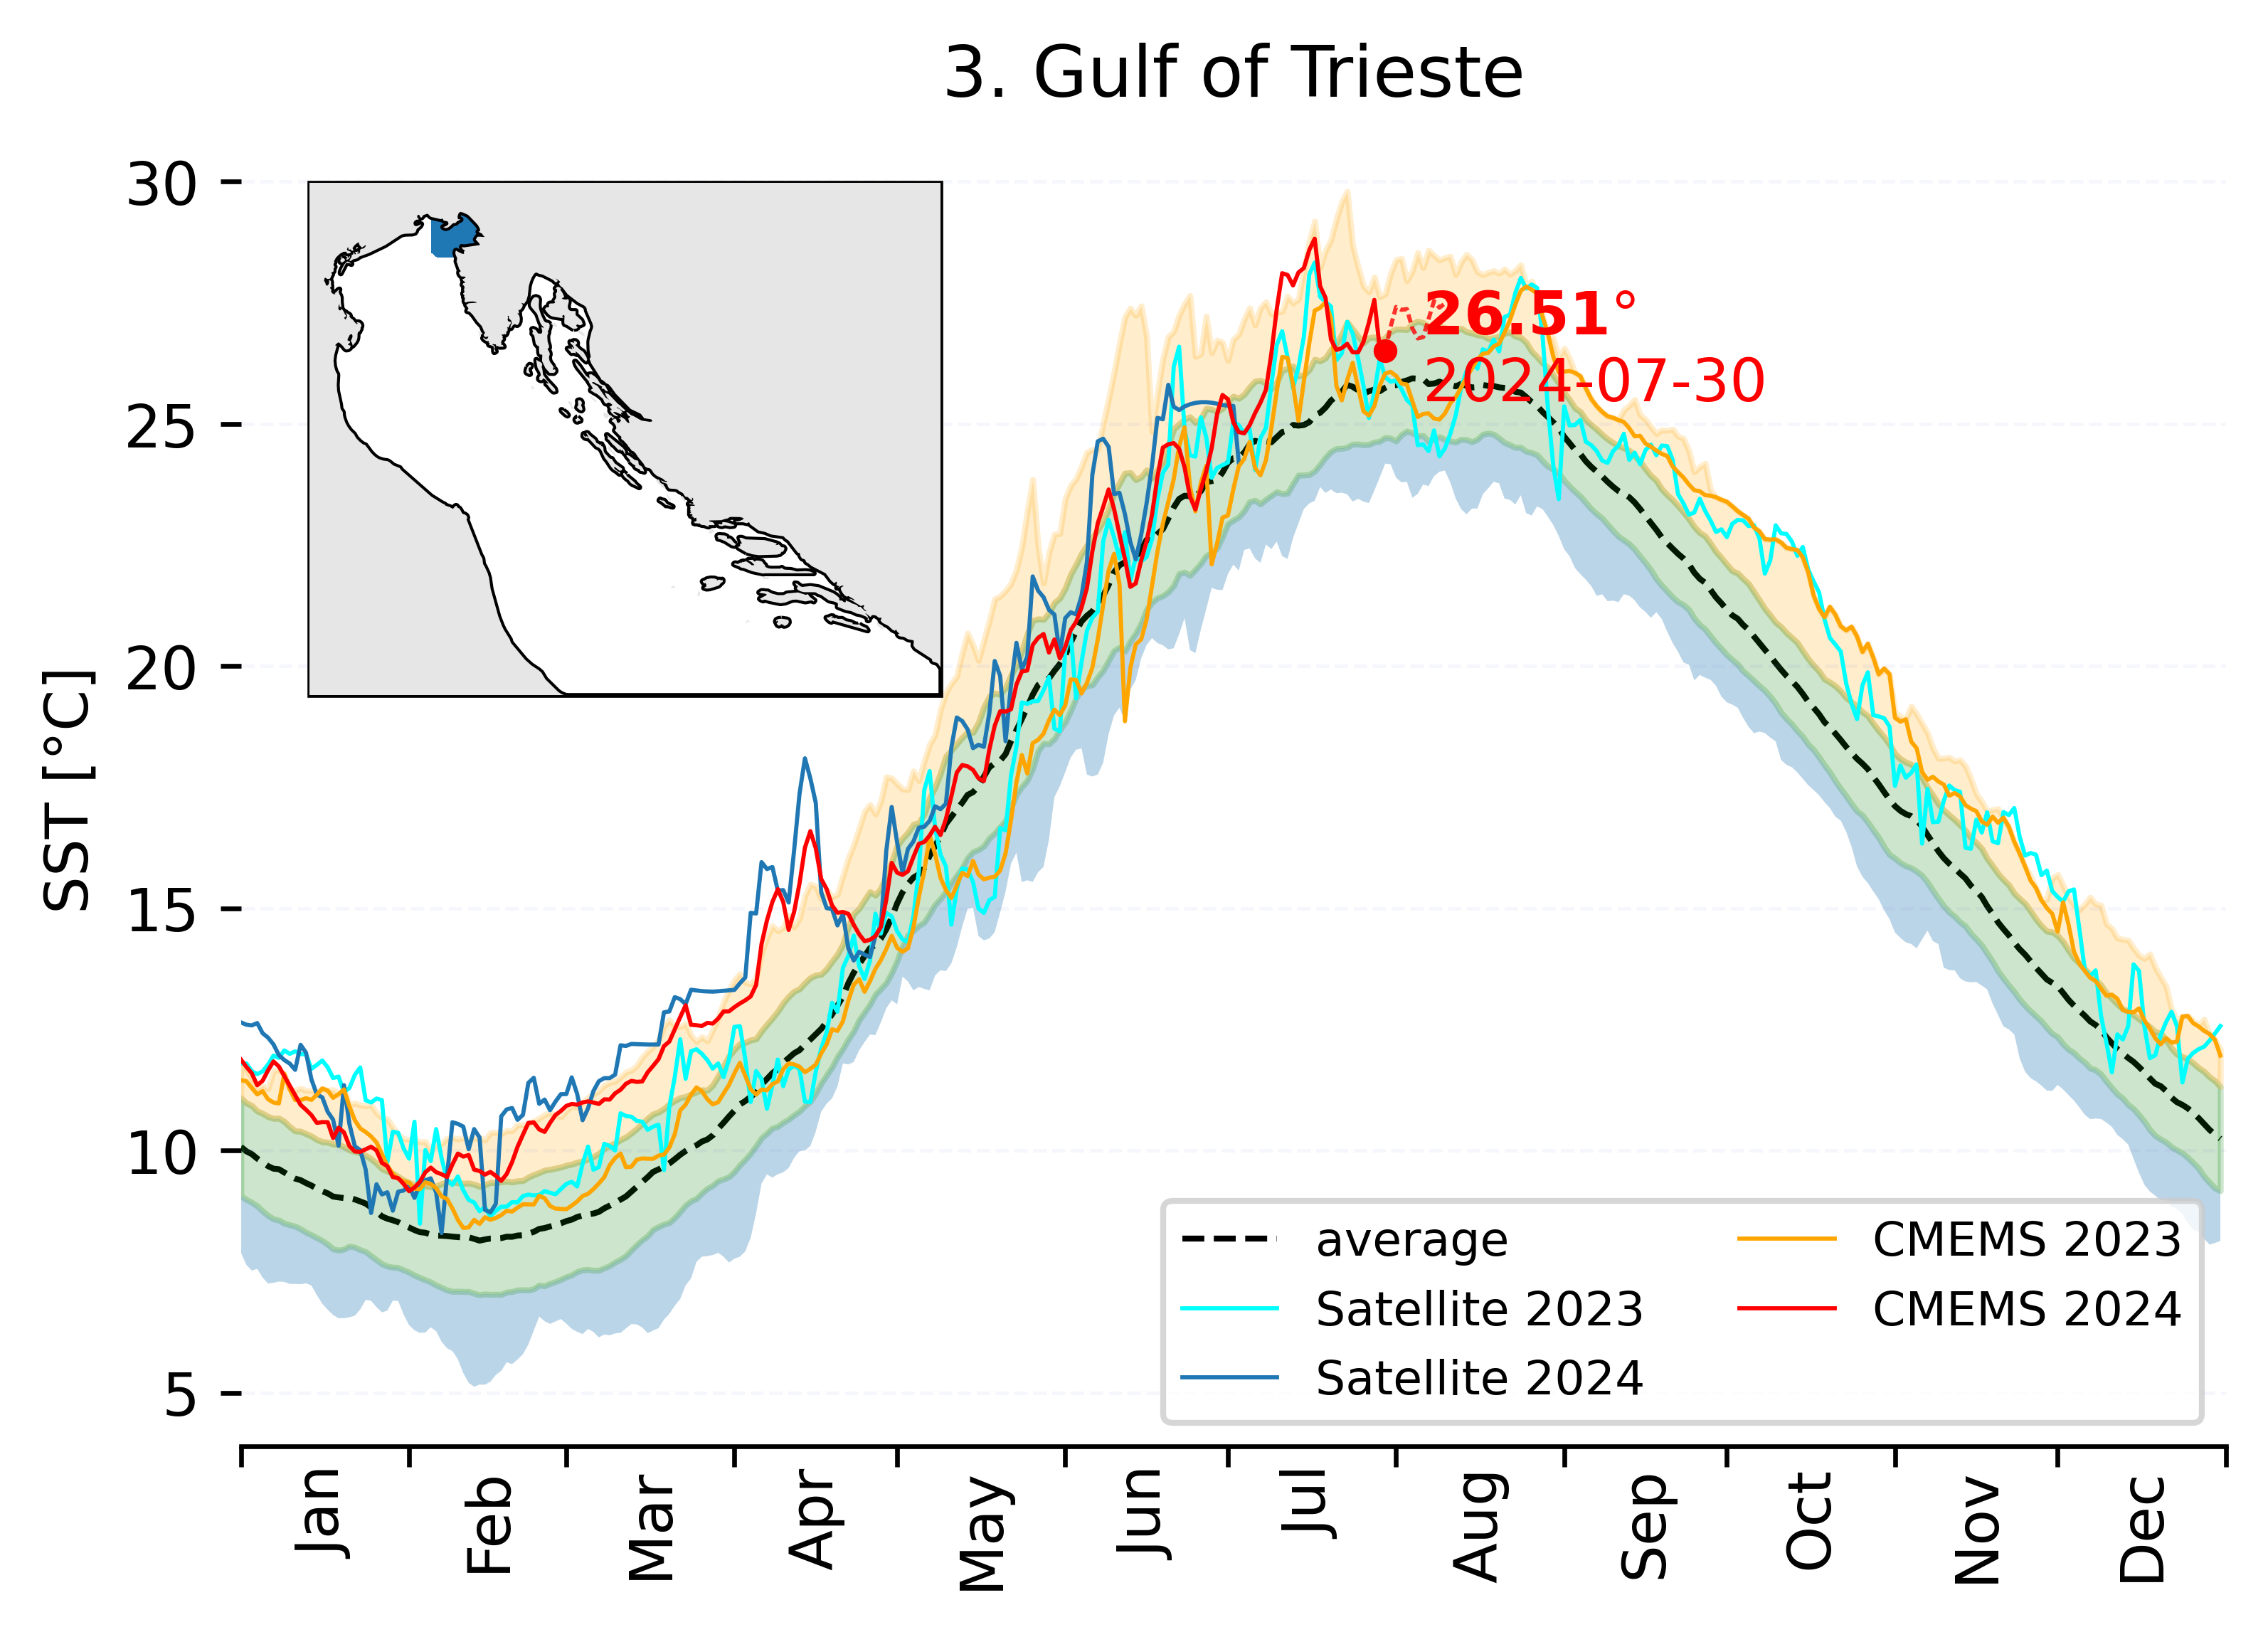

In [19]:
# Generate the plots for each basin
for i, basin in enumerate(basins, 1):
    SeasonalPlotterWithBasin(basin).plot(dpi=600, figsize=(6,4), title=f'{i}. {basin.extended_name}')
    plt.show()
    plt.close()